# Assignment 8: Neural Networks

Only use the already imported library `numpy` and the Python standard library. For the evaluation you may also use scikit-learn (`sklearn`) and `matplotlib`. Make sure that the dataset `airfoil_self_noise.csv` is in the same directory as the notebook.

List your team members (name and immatriculation number) and indicate whether you are a B.Sc. Data Science or other group in the following cell:

==> *Write*
* *names* Srinivas Kumar Ramdas, Benedikt Riegel, Fozan Gill 
* *matr. nr.* 3513675, 3568633, 3437081
* *study program* Computer Science, Computer Science, Computer Science
* *B.Sc./M.Sc.* M.Sc., M.Sc, M.Sc

*of all assignment group participants here. (double klick here to edit)*

In [73]:
import numpy as np
import matplotlib.pyplot as plt


def load_dataset(path):
    from sklearn.model_selection import train_test_split
    
    data = np.genfromtxt(path)
    X, y = data[:, :5], data[:, 5]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

    return X_train, X_test, y_train, y_test
    

X_train, X_test, y_train, y_test = load_dataset('airfoil_self_noise.csv')

In [74]:
X_train_max = np.max(X_train, axis=0)
X_train_min = np.min(X_test, axis=0)

y_train_max = np.max(y_train, axis=0)
y_train_min = np.min(y_train, axis=0)

def normalize_dataset():
    global X_train, X_test, y_train
    X_train = (X_train - X_train_min)/(X_train_max - X_train_min)
    X_test = (X_test - X_train_min)/(X_train_max - X_train_min)
    
    y_train = (y_train - y_train_min)/(y_train_max - y_train_min)

    return

#normalize_dataset()


## Task 3: Feedforward Neural Network: Programming (40 Points)

In this task, you will implement a feedforward neural network for regression. The hyperparameters of the model are:
- `input_dim`: The dimension of the input vector.
- `output_dim`: The dimension of the output vector.
- `width`: The dimension of each hidden layer.
- `depth`: The number of hidden layers. For B.Sc. Data Science students, this parameter is constant with a value of 1.
- `learning_rate`: The learning rate for gradient descent.
- `epochs`: The number of epochs/iterations performed during training.

B.Sc. Data Science only have to implement for a single hidden layer, i.e. `depth = 1`. All other students have to implement the network for any `depth >= 1`.

The activation function for each hidden layer is ReLU (g(x) = max(0, x)). The output layer uses the identity as activation, since our objective is regression.

You have to implement the `FeedforwardNeuralNetworkRegressor`.

The `__init__` method initializes the network.
Initialize each weight and bias randomly with a standard Gaussian distribution using the numpy function `numpy.random.normal` with default parameters.

The `fit` method trains the network.
Use backpropagation with gradient descent similar to Task 2.
Use the whole training data set for each training epoch.
Use the mean squared error as loss function.

The `predict` method computes the forward-pass of the network.

Evaluate your classifier on the test data with the mean squared error and compare your results to your linear regression model from assignment 3. Try out different hyper-parameters and compare the results. You may want to normalize your input and output data for better performance.

In [75]:
class FeedforwardNeuralNetworkClassifier(object):
    def __init__(self, input_dim, output_dim, width, depth, learning_rate, epochs):
        # Add your code, such as initialization of weights here.
        
        self.weights_list = []
        self.biases_list = []
        self.memory = {}
        
        self.depth = depth
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        prev_dim = input_dim
        curr_dim = width
        
        np.random.seed(27)
        
        for layer in range(depth):
            self.weights_list.append(np.random.normal(size = (curr_dim, prev_dim)))
            self.biases_list.append(np.random.normal(size = (curr_dim, 1)))
            
            prev_dim = curr_dim
            curr_dim = width
        
        #Appending the final output layer
        self.weights_list.append(np.random.normal(size = (output_dim, prev_dim)))
        self.biases_list.append(np.random.normal(size = (output_dim, 1)))
        
    
    def relu(self, z):
        return z*(z > 0)
    
    def relu_backward(self, dA, z):
        dZ = np.array(dA, copy=True)
        dZ[z <= 0] = True
        return dZ
    
    def identity_backward(self, dA, z):
        dZ = np.array(dA, copy=True)
        return dZ
        
    def identity(self, z):
        return z
    
    def single_layer_backward_propagation(self, dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
        m = A_prev.shape[1]
        
        if activation == "relu":
            backward_activation_func = self.relu_backward
        else:
            backward_activation_func = self.identity_backward
        
        dZ_curr = backward_activation_func(dA_curr, Z_curr)
        
        # Derivative of matrix W
        dW_curr = np.dot(dZ_curr, A_prev.T)/m 
        
        #Derivative of the vector b
        db_curr = np.sum(dZ_curr, axis=1, keepdims=True)/m
        
        #Derivative of matrix A_prev
        dA_prev = np.dot(W_curr.T, dZ_curr)
        
        return dA_prev, dW_curr, db_curr
    
    def full_backward_propagation(self, Y_hat, Y):
        grad_values = {}
        
        #Number of values
        m = Y.shape[0]
        
        #Initiation of gradient descent algorithm
        dA_prev = (2/m)*(Y_hat - Y)
        
        for idx in range(len(self.weights_list) - 1 , -1, -1):
            layer_idx = idx + 1
            
            activation = "relu"
            if (layer_idx == len(self.weights_list)):
                activation = "identity"
            
            dA_curr = dA_prev
            
            A_prev = self.memory["A" + str(idx)]
            z_curr = self.memory["Z" + str(layer_idx)]
            
            W_curr = self.weights_list[idx]
            b_curr = self.biases_list[idx]
            
            dA_prev, dW_curr, db_curr = self.single_layer_backward_propagation(dA_curr, W_curr, b_curr, z_curr, A_prev, activation)
            grad_values["dW" + str(idx)] = dW_curr
            grad_values["db" + str(idx)] = db_curr
            
        return grad_values
    
    def update(self, grad_values):
        for idx in range(len(self.weights_list) - 1, -1, -1):
            self.weights_list[idx] -= self.learning_rate*grad_values["dW" + str(idx)]
            self.biases_list[idx] -= self.learning_rate*grad_values["db" + str(idx)]
        
        return
    
    def forward_pass(self, X):
        z_prev = X
        A_curr = None
        
        A_curr = X 
        z_curr = None
        
        for idx in range(len(self.weights_list) - 1 ):
            
            A_prev = A_curr 
            z_curr = np.dot(self.weights_list[idx], A_prev) + self.biases_list[idx]
            A_curr = self.relu(z_curr)
            
            #Storing in memory
            self.memory["A" + str(idx)] =  A_prev
            self.memory["Z" + str(idx+1)] = z_curr
                    
        idx = len(self.weights_list) - 1
        A_prev = A_curr
        z_curr = np.dot(self.weights_list[idx], A_prev) + self.biases_list[idx]
        A_curr = self.identity(z_curr)
        
        #Storing in memory
        self.memory["A" + str(idx)] =  A_prev
        self.memory["Z" + str(idx+1)] = z_curr
        
        return A_curr
    
    def compute_rmse(self, y, y_hat):
        return (np.mean((y - y_hat)**2))
    
    def fit(self, X, y):
        # Implement your training here.
        
        epochs = []
        errors = []
        
        for epoch in range(self.epochs):
            y_hat = self.forward_pass(X)

            #print("The error is : " + str(self.compute_rmse(y, y_hat)))
            grad_values = self.full_backward_propagation(y_hat, y)
            self.update(grad_values)
            
            epochs.append(epoch)
            errors.append(self.compute_rmse(y, y_hat))
            
            if epoch%100 == 0:
                print("After epoch %s error is %s " % (epoch, self.compute_rmse(y, y_hat), 
                                                                ))
        
        self.plot(epochs, errors)
        return 
    
    def plot(self, epochs, errors):
        plt.plot(epochs, errors)
        plt.title("Error vs Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Error")
        plt.yscale('log')
        plt.show()
    
    def predict(self, X):
        # Implement your prediction here.
        y_hat = self.forward_pass(X)
        return y_hat


After epoch 0 error is 12826704.374085514 
After epoch 100 error is 15063.305860570163 
After epoch 200 error is 14503.062675718034 
After epoch 300 error is 13963.723565717253 
After epoch 400 error is 13444.508547236997 
After epoch 500 error is 12944.666740075894 
After epoch 600 error is 12463.475281251442 
After epoch 700 error is 12000.238279607494 
After epoch 800 error is 11554.285809427918 
After epoch 900 error is 11124.972941601089 
After epoch 1000 error is 10711.678810934034 
After epoch 1100 error is 10313.805718267413 
After epoch 1200 error is 9930.778266092844 
After epoch 1300 error is 9562.042526422536 
After epoch 1400 error is 9207.06523970774 
After epoch 1500 error is 8865.333043647594 
After epoch 1600 error is 8536.351730773007 
After epoch 1700 error is 8219.64553373198 
After epoch 1800 error is 7914.75643724271 
After epoch 1900 error is 7621.243515719417 
After epoch 2000 error is 7338.682295613026 
After epoch 2100 error is 7066.66414154456 
After epoch 22

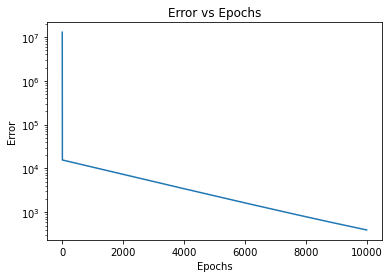

399.5961322987295

In [77]:
# Implement your training and evaluation here.
X_train_T = X_train.T
X_test_T = X_test.T

input_dim = X_train_T.shape[0]
output_dim = 1
width = 2
depth = 2
learning_rate = 0.1
epochs = 10000

ffnn = FeedforwardNeuralNetworkClassifier(input_dim, output_dim, width, depth, learning_rate, epochs)
y_hat = ffnn.fit(X_train_T, y_train)
#print(ffnn.memory.keys())
#grad_values = ffnn.full_backward_propagation(y_hat, y_train)
#ffnn.update(grad_values)
y_hat_test = ffnn.predict(X_test_T)

# Rescaling the test predictions
#y_hat_test = y_hat_test*(y_train_max - y_train_min) + y_train_min

#print(y_hat_test)
ffnn.compute_rmse(y_test, y_hat_test)